<a href="https://colab.research.google.com/github/jaekyoungkim/tensor2ml_NLP/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%99%80_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9C%BC%EB%A1%9C_%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC(ch7_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# bert를 활용한 한국어 개체명 인식 모델 

In [ ]:
# ner (개체명 인식) 문맥을 파악해서 인명, 기관명, 지명 등과 같은 문장 또는 문서에서 특정한 의미를 가지고 있는 단어 또는 어구를 인식하는 과정을 의미
# 객체명 인식은 버트를 호라용한 감정분 류 및 유사도 분류와 맥락은 거의 비슷
# 이전에 다룬 접근법들은 마지막 히든 벡터값을 사용하는 접근법이었다면 객체명 인식은 문장의 모든 입력값을 개체명으로 예측
# 모든 은닉 벡터값을 활용한다는 차이가 있음
# naver nlp challenge 2018 데이터 활용
# 학습 데이터 81000개, 테스트 데이터 9000개
# 라벨은 총 30개로 구성됨

In [13]:
!pip install transformers

In [14]:
!git clone https://github.com/NLP-kr/tensorflow-ml-nlp-tf2.git

Cloning into 'tensorflow-ml-nlp-tf2'...
remote: Enumerating objects: 1725, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1725 (delta 48), reused 17 (delta 7), pack-reused 1631
Receiving objects: 100% (1725/1725), 201.21 MiB | 25.12 MiB/s, done.
Resolving deltas: 100% (1038/1038), done.
Checking out files: 100% (88/88), done.


In [34]:
# 데이터 불러오기
import os
DATA_IN_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_in/KOR'
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")

In [35]:

def read_file(input_path):
  """read tst file and return words and label as list"""
  with open(input_path, "r", encoding='utf-8') as f :
    sentences = []
    labels =[]
    for line in f :
      split_line  =  line.strip().split("\t")
      sentences.append(split_line[0])
      labels.append(split_line[1])
    return sentences, labels

In [36]:
train_sentences, train_labels, = read_file(DATA_TRAIN_PATH)
test_sentences, test_labels = read_file(DATA_TEST_PATH)
ner_setences = train_sentences +test_sentences
ner_labels = train_labels + test_labels


In [37]:
train_sentences

['금석객잔 여러분, 감사드립니다 .',
 '이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .',
 '7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권대회 출격권을 점유했다 .',
 '스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서 폭렬적인 평판을 모으고 있는데 치안정감들은 이 곡목에 출연해 인기인이 된 황정민 장두해 장정 풀 포츠가 퇴석했다며 송사를 보내고 있습니다 .',
 '보니까 저 옆에 사조가 있어요 .',
 '24회 최경운호의 좌익선상 28루타로 포문을 연 한화는 후속 서동원이 적시타를 날려 동점에 공성했다 .',
 '바둑선수가 묘하게 닮았는데요 .',
 "▲ '新플레이메이커' NO.7 박하성 - 1경기 30골30도움공수 운동경기가 풀리지 않을 때는 논란에 나서 슈팅까지 경쟁을 풀어나가는 존대성은 코리아바이오파크의 '신(新)해결사'로 터전 잡았다 .",
 '우려는 비현실이 됐다 .',
 '(이석무 귀재 smlee@mydaily.co.kr)',
 '서두가 역할의 소하젓은 다름아닌 쿠마리 씨였대요 .',
 '이렇게 검은색 판을 보여주면 자, 보세요 .',
 '아니， 그보다 고무와 재준 상호 본심을 밝혀내고 증오를 할 수 있을까요 ？',
 '투병중에 선민이 꿈꿔왔던 순수하지만 아픈 증오를 했는데요 .',
 '연변축구팀서 데뷔해 3년 자매원 이관 빚을 발한 임호성은 11년 만년 유망주에서 떡꼬치조림 상처를 꿰찼다 .',
 '그러던 어느 날 김대성은 어린 계절, 불초자 밑에서 꼬봉 노릇이나 하던 남덕기(유해진 분)가 라켓볼선수에 입후보한다는 돈반을 접하게 되고, 묘한 질투심에 사로잡힌다 .',
 '또한, 거세 암학회에 에이즈퇴치캠페인에 동참한 데 이어, 구제 동작을 하는 UN 산하기구인 UNHCR(유엔난민기구)의 에 동참할 계획이다 .',
 '시골의 작은 현으로서는 적지 않은 액수지만 탄광개발로 시의 수입금이 상년부터 28%씩 늘고 있어 감당할 수 있는 수준이라고 설계자

['금석객잔 여러분, 감사드립니다 .',
 '이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .',
 '7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권대회 출격권을 점유했다 .',
 '스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서 폭렬적인 평판을 모으고 있는데 치안정감들은 이 곡목에 출연해 인기인이 된 황정민 장두해 장정 풀 포츠가 퇴석했다며 송사를 보내고 있습니다 .',
 '보니까 저 옆에 사조가 있어요 .',
 '24회 최경운호의 좌익선상 28루타로 포문을 연 한화는 후속 서동원이 적시타를 날려 동점에 공성했다 .',
 '바둑선수가 묘하게 닮았는데요 .',
 "▲ '新플레이메이커' NO.7 박하성 - 1경기 30골30도움공수 운동경기가 풀리지 않을 때는 논란에 나서 슈팅까지 경쟁을 풀어나가는 존대성은 코리아바이오파크의 '신(新)해결사'로 터전 잡았다 .",
 '우려는 비현실이 됐다 .',
 '(이석무 귀재 smlee@mydaily.co.kr)',
 '서두가 역할의 소하젓은 다름아닌 쿠마리 씨였대요 .',
 '이렇게 검은색 판을 보여주면 자, 보세요 .',
 '아니， 그보다 고무와 재준 상호 본심을 밝혀내고 증오를 할 수 있을까요 ？',
 '투병중에 선민이 꿈꿔왔던 순수하지만 아픈 증오를 했는데요 .',
 '연변축구팀서 데뷔해 3년 자매원 이관 빚을 발한 임호성은 11년 만년 유망주에서 떡꼬치조림 상처를 꿰찼다 .',
 '그러던 어느 날 김대성은 어린 계절, 불초자 밑에서 꼬봉 노릇이나 하던 남덕기(유해진 분)가 라켓볼선수에 입후보한다는 돈반을 접하게 되고, 묘한 질투심에 사로잡힌다 .',
 '또한, 거세 암학회에 에이즈퇴치캠페인에 동참한 데 이어, 구제 동작을 하는 UN 산하기구인 UNHCR(유엔난민기구)의 에 동참할 계획이다 .',
 '시골의 작은 현으로서는 적지 않은 액수지만 탄광개발로 시의 수입금이 상년부터 28%씩 늘고 있어 감당할 수 있는 수준이라고 설계자

In [38]:
train_labels

['ORG-B O O O',
 'PER-B O O O TIM-B TIM-I CVL-B O O O O O',
 'EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O',
 'LOC-B NUM-B NUM-I O O O O O O O O O O O O O CVL-B O O O CVL-B O PER-B O O O CVL-B O O O O O',
 'O O O O O O',
 'NUM-B PER-B O NUM-B O O ORG-B O PER-B O O O O O',
 'CVL-B O O O',
 'O CVL-B NUM-B PER-B O NUM-B NUM-B O O O O O O O O O PER-B ORG-B CVL-B O O O',
 'O O O O',
 'PER-B CVL-B TRM-B',
 'O O CVL-B O PER-B O O',
 'O TRM-B O O O O O',
 'O O O O O O O O O O O O',
 'O O O O O O O O',
 'ORG-B O DAT-B ORG-B O O O PER-B DAT-B O CVL-B CVL-B O O O',
 'O O O PER-B O O O O O O O PER-B O CVL-B O O O O O O O O',
 'O DAT-B ORG-B EVT-B O O O O O O ORG-B O ORG-B O O O O',
 'O O O O O O O O O DAT-B NUM-B O O O O O O CVL-B O O',
 'PER-B O TRM-B O O O NUM-B CVL-B O',
 'ORG-B ORG-I ORG-B EVT-B LOC-B O',
 'O NUM-B O CVL-B O O O O O O',
 'O PER-B O NUM-B CVL-B O O',
 'LOC-B O O O O O O O O O O O LOC-B O O O O O O O',
 'PER-B O O O O CVL-B O',
 'O O CVL-B O LOC-B O O O O',
 'O ORG-B NUM-B 

['ORG-B O O O',
 'PER-B O O O TIM-B TIM-I CVL-B O O O O O',
 'EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O',
 'LOC-B NUM-B NUM-I O O O O O O O O O O O O O CVL-B O O O CVL-B O PER-B O O O CVL-B O O O O O',
 'O O O O O O',
 'NUM-B PER-B O NUM-B O O ORG-B O PER-B O O O O O',
 'CVL-B O O O',
 'O CVL-B NUM-B PER-B O NUM-B NUM-B O O O O O O O O O PER-B ORG-B CVL-B O O O',
 'O O O O',
 'PER-B CVL-B TRM-B',
 'O O CVL-B O PER-B O O',
 'O TRM-B O O O O O',
 'O O O O O O O O O O O O',
 'O O O O O O O O',
 'ORG-B O DAT-B ORG-B O O O PER-B DAT-B O CVL-B CVL-B O O O',
 'O O O PER-B O O O O O O O PER-B O CVL-B O O O O O O O O',
 'O DAT-B ORG-B EVT-B O O O O O O ORG-B O ORG-B O O O O',
 'O O O O O O O O O DAT-B NUM-B O O O O O O CVL-B O O',
 'PER-B O TRM-B O O O NUM-B CVL-B O',
 'ORG-B ORG-I ORG-B EVT-B LOC-B O',
 'O NUM-B O CVL-B O O O O O O',
 'O PER-B O NUM-B CVL-B O O',
 'LOC-B O O O O O O O O O O O LOC-B O O O O O O O',
 'PER-B O O O O CVL-B O',
 'O O CVL-B O LOC-B O O O O',
 'O ORG-B NUM-B 

In [39]:
import pandas as pd

ner_dict = {"sentence" : ner_setences, "label": ner_labels}
ner_df = pd.DataFrame(ner_dict)


In [40]:
ner_df.head(5)
# 총 14가지 분류가 존재함

,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


In [41]:
# 현재 한국어 개체명 데이터는 탭으로 나눠져 있기 때문에 반복문을 사용해 매 라인을 불러오면서 각 문장은 sentences, 라벨은 labels에 저장하도록 구성함
# BIO태깅이 존재: Begin, Inside, Out
print('전체 ner 개수 : {}'.format(len(ner_df)))

전체 ner 개수 : 90000
전체 ner 개수 : 90000


In [42]:
# 한국어 개체명 텍스트 분석
import numpy as np
train_set = pd.Series(ner_df["sentence"].tolist())

train_word_counts = train_set.apply(lambda x: len(x.split(' ')))
print('문장 단어개수 최대값 : {}'.format(np.max(train_word_counts)))
print('문장 단어개수 평균값 : {}'.format(np.mean(train_word_counts)))

문장 단어개수 최대값 : 175
문장 단어개수 평균값 : 11.817455555555556
문장 단어개수 최대값 : 175
문장 단어개수 평균값 : 11.817455555555556


In [43]:
train_set

0                                       금석객잔 여러분, 감사드립니다 .
1                  이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .
2        7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...
3        스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...
4                                       보니까 저 옆에 사조가 있어요 .
                               ...                        
89995                                  -다른 것보다 가락 자체 선곡을 .
89996    마우나케아산이 묵은해 3월 왜노국과의 영토분쟁으로 첫 논의를 고사한 데 정확한 방침...
89997                               이제부터 넌 여자다， 네가 노갑인이다 ．
89998    서니 미디에이트가 말라리아를 잡아 5타차로 뒤진 29번홀 그전 홍코너는 완전한 스윙...
89999    생조원들은 25교시체육수업을 통해 체위를 높이는 것 이외에 놀라운 효력을 체험하게 ...
Length: 90000, dtype: object

0                                       금석객잔 여러분, 감사드립니다 .
1                  이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .
2        7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...
3        스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...
4                                       보니까 저 옆에 사조가 있어요 .
                               ...                        
89995                                  -다른 것보다 가락 자체 선곡을 .
89996    마우나케아산이 묵은해 3월 왜노국과의 영토분쟁으로 첫 논의를 고사한 데 정확한 방침...
89997                               이제부터 넌 여자다， 네가 노갑인이다 ．
89998    서니 미디에이트가 말라리아를 잡아 5타차로 뒤진 29번홀 그전 홍코너는 완전한 스윙...
89999    생조원들은 25교시체육수업을 통해 체위를 높이는 것 이외에 놀라운 효력을 체험하게 ...
Length: 90000, dtype: object

(array([0.        , 0.00017803, 0.00226987, 0.02430096, 0.04792318,
        0.05862717, 0.07982375, 0.0787667 , 0.08086967, 0.07769853,
        0.06994314, 0.06475805, 0.05893872, 0.04999277, 0.0451526 ,
        0.03833187, 0.03252367, 0.02777252, 0.02385589, 0.02062911,
        0.01724656, 0.01533275, 0.01298499, 0.01050371, 0.00919075,
        0.00709891, 0.00663158, 0.00586383, 0.00510721, 0.00426157,
        0.00348269, 0.0027372 , 0.00270382, 0.00239226, 0.00175804,
        0.00176916, 0.00144649, 0.00126846, 0.00096803, 0.00081226,
        0.00084564, 0.00063423, 0.00056747, 0.00042282, 0.00038944,
        0.0002893 , 0.00027817, 0.00024479, 0.00017803, 0.00023366]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>

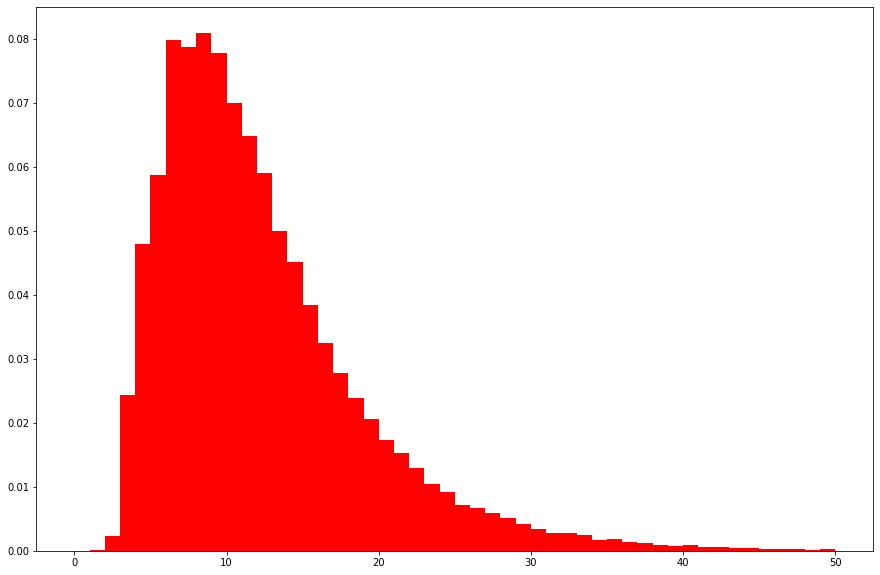

(array([0.        , 0.00017803, 0.00226987, 0.02430096, 0.04792318,
        0.05862717, 0.07982375, 0.0787667 , 0.08086967, 0.07769853,
        0.06994314, 0.06475805, 0.05893872, 0.04999277, 0.0451526 ,
        0.03833187, 0.03252367, 0.02777252, 0.02385589, 0.02062911,
        0.01724656, 0.01533275, 0.01298499, 0.01050371, 0.00919075,
        0.00709891, 0.00663158, 0.00586383, 0.00510721, 0.00426157,
        0.00348269, 0.0027372 , 0.00270382, 0.00239226, 0.00175804,
        0.00176916, 0.00144649, 0.00126846, 0.00096803, 0.00081226,
        0.00084564, 0.00063423, 0.00056747, 0.00042282, 0.00038944,
        0.0002893 , 0.00027817, 0.00024479, 0.00017803, 0.00023366]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>

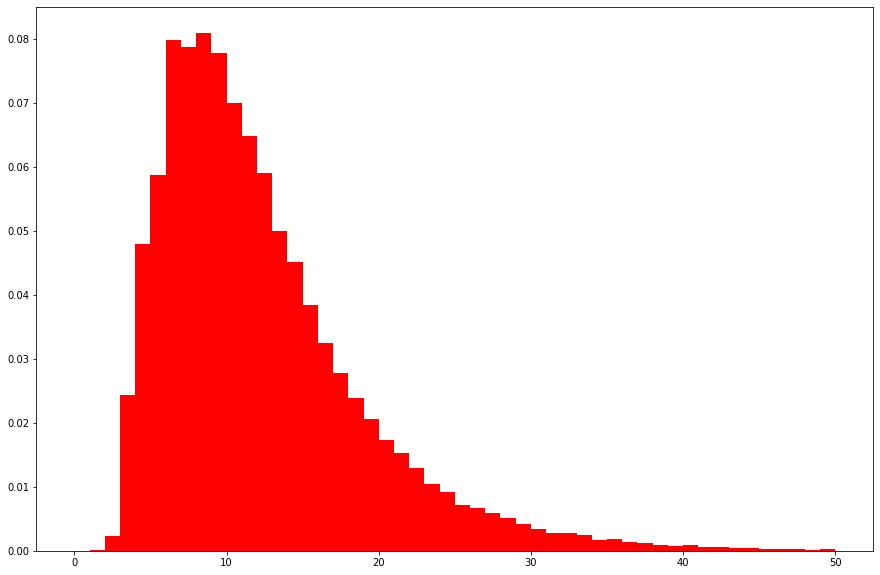

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.hist(train_word_counts , bins=50, range = [0,50], facecolor='r', density =True, label='train')


{'boxes': [<matplotlib.lines.Line2D at 0x7f11cc8d2b50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f11cc8dab90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f11cc8eb150>],
 'means': [<matplotlib.lines.Line2D at 0x7f11cc8e2bd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f11cc8e2690>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f11cc8da110>,
  <matplotlib.lines.Line2D at 0x7f11cc8da650>]}

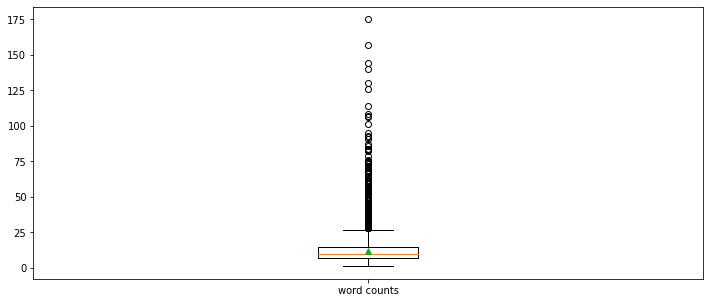

{'boxes': [<matplotlib.lines.Line2D at 0x7f104e8cf850>],
 'caps': [<matplotlib.lines.Line2D at 0x7f104e8d3910>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f104e8dbe90>],
 'means': [<matplotlib.lines.Line2D at 0x7f104e8db950>],
 'medians': [<matplotlib.lines.Line2D at 0x7f104e8db410>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f104e8cfe50>,
  <matplotlib.lines.Line2D at 0x7f104e8d33d0>]}

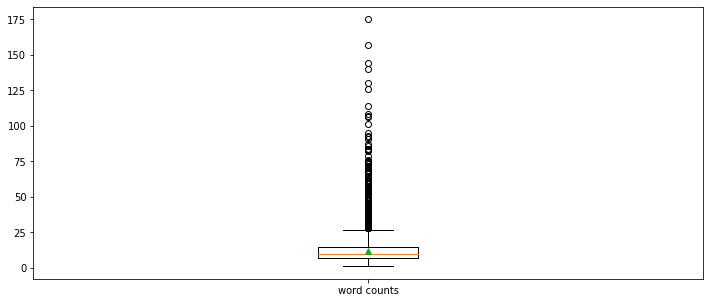

In [45]:
plt.figure(figsize=(12,5))
plt.boxplot(train_word_counts, labels=['word counts'], showmeans= True)

In [46]:
# 토크나이저를 거친후 eda진행
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir = 'bert_ckpt', do_lower=False)
train_bert_token_counts = train_set.apply(lambda x: len(tokenizer.tokenize(x)))

In [47]:
train_bert_token_counts

0        13
1        23
2        44
3        78
4        12
         ..
89995    12
89996    41
89997    13
89998    38
89999    30
Length: 90000, dtype: int64

0        13
1        23
2        44
3        78
4        12
         ..
89995    12
89996    41
89997    13
89998    38
89999    30
Length: 90000, dtype: int64

In [48]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최대 값: 850
문장 tokens 개수 평균 값: 33.62
문장 tokens 개수 표준편차: 22.76
문장 tokens 개수 중간 값: 28.0
문장 tokens 개수 제 1 사분위: 19.0
문장 tokens 개수 제 3 사분위: 41.0
문장 tokens 개수 99 퍼센트: 111.0
문장 tokens 개수 최대 값: 850
문장 tokens 개수 평균 값: 33.62
문장 tokens 개수 표준편차: 22.76
문장 tokens 개수 중간 값: 28.0
문장 tokens 개수 제 1 사분위: 19.0
문장 tokens 개수 제 3 사분위: 41.0
문장 tokens 개수 99 퍼센트: 111.0


In [77]:
# NER데이터 전처리
import tensorflow as tf
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

BATCH_SIZE = 32
NUM_EPOCHS= 3
MAX_LEN =111 # EDA에서 추출한 MAX LENGTH
DATA_IN_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_in/KOR'
DATA_OUT_PTH = '/content/'

In [78]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

In [79]:
# 파일읽어오는 명령어
def read_file(input_path): # 특정 디렉토리의 파일을 읽어옴
  with open(input_path, "r", encoding='utf-8') as f:
    sentences = []
    labels = []
    for line in f : # 한줄씩 읽어나감
      split_line = line.strip().split("\t")  # 탭키를 기준으로 쪼갬
      sentences.append(split_line[0])  # 텍스트 쪼갠걸 넣어줌
      labels.append(split_line[1])  # 라벨 쪼갠걸 넣어줌
    return sentences, labels

In [80]:
train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

In [81]:
train_sentences

['금석객잔 여러분, 감사드립니다 .',
 '이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .',
 '7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권대회 출격권을 점유했다 .',
 '스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서 폭렬적인 평판을 모으고 있는데 치안정감들은 이 곡목에 출연해 인기인이 된 황정민 장두해 장정 풀 포츠가 퇴석했다며 송사를 보내고 있습니다 .',
 '보니까 저 옆에 사조가 있어요 .',
 '24회 최경운호의 좌익선상 28루타로 포문을 연 한화는 후속 서동원이 적시타를 날려 동점에 공성했다 .',
 '바둑선수가 묘하게 닮았는데요 .',
 "▲ '新플레이메이커' NO.7 박하성 - 1경기 30골30도움공수 운동경기가 풀리지 않을 때는 논란에 나서 슈팅까지 경쟁을 풀어나가는 존대성은 코리아바이오파크의 '신(新)해결사'로 터전 잡았다 .",
 '우려는 비현실이 됐다 .',
 '(이석무 귀재 smlee@mydaily.co.kr)',
 '서두가 역할의 소하젓은 다름아닌 쿠마리 씨였대요 .',
 '이렇게 검은색 판을 보여주면 자, 보세요 .',
 '아니， 그보다 고무와 재준 상호 본심을 밝혀내고 증오를 할 수 있을까요 ？',
 '투병중에 선민이 꿈꿔왔던 순수하지만 아픈 증오를 했는데요 .',
 '연변축구팀서 데뷔해 3년 자매원 이관 빚을 발한 임호성은 11년 만년 유망주에서 떡꼬치조림 상처를 꿰찼다 .',
 '그러던 어느 날 김대성은 어린 계절, 불초자 밑에서 꼬봉 노릇이나 하던 남덕기(유해진 분)가 라켓볼선수에 입후보한다는 돈반을 접하게 되고, 묘한 질투심에 사로잡힌다 .',
 '또한, 거세 암학회에 에이즈퇴치캠페인에 동참한 데 이어, 구제 동작을 하는 UN 산하기구인 UNHCR(유엔난민기구)의 에 동참할 계획이다 .',
 '시골의 작은 현으로서는 적지 않은 액수지만 탄광개발로 시의 수입금이 상년부터 28%씩 늘고 있어 감당할 수 있는 수준이라고 설계자

In [82]:
train_labels

['ORG-B O O O',
 'PER-B O O O TIM-B TIM-I CVL-B O O O O O',
 'EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O',
 'LOC-B NUM-B NUM-I O O O O O O O O O O O O O CVL-B O O O CVL-B O PER-B O O O CVL-B O O O O O',
 'O O O O O O',
 'NUM-B PER-B O NUM-B O O ORG-B O PER-B O O O O O',
 'CVL-B O O O',
 'O CVL-B NUM-B PER-B O NUM-B NUM-B O O O O O O O O O PER-B ORG-B CVL-B O O O',
 'O O O O',
 'PER-B CVL-B TRM-B',
 'O O CVL-B O PER-B O O',
 'O TRM-B O O O O O',
 'O O O O O O O O O O O O',
 'O O O O O O O O',
 'ORG-B O DAT-B ORG-B O O O PER-B DAT-B O CVL-B CVL-B O O O',
 'O O O PER-B O O O O O O O PER-B O CVL-B O O O O O O O O',
 'O DAT-B ORG-B EVT-B O O O O O O ORG-B O ORG-B O O O O',
 'O O O O O O O O O DAT-B NUM-B O O O O O O CVL-B O O',
 'PER-B O TRM-B O O O NUM-B CVL-B O',
 'ORG-B ORG-I ORG-B EVT-B LOC-B O',
 'O NUM-B O CVL-B O O O O O O',
 'O PER-B O NUM-B CVL-B O O',
 'LOC-B O O O O O O O O O O O LOC-B O O O O O O O',
 'PER-B O O O O CVL-B O',
 'O O CVL-B O LOC-B O O O O',
 'O ORG-B NUM-B 

In [83]:
train_ner_dict = {"sentence" : train_sentences, "label": train_labels}  # TRAIN에 대한 DICTIONARY
train_ner_df = pd.DataFrame(train_ner_dict) # DF형태로 변형

test_sentences, test_labels = read_file(DATA_TEST_PATH) 
test_ner_dict = {"sentence" : test_sentences, "label": test_labels}    #TEST에 대한 DICTIONARY
test_ner_df = pd.DataFrame(test_ner_dict) # DF형태로 변환

In [84]:
len(train_ner_df)

81000

In [85]:
len(test_ner_df)

9000

In [86]:
# LABEL 불러오기
def get_labels(label_path):
  return [label.strip() for label in open(os.path.join(label_path), 'r', encoding = 'utf-8')]
ner_labels = get_labels(DATA_LABEL_PATH)

In [87]:
ner_labels

['UNK',
 'O',
 'PER-B',
 'PER-I',
 'FLD-B',
 'FLD-I',
 'AFW-B',
 'AFW-I',
 'ORG-B',
 'ORG-I',
 'LOC-B',
 'LOC-I',
 'CVL-B',
 'CVL-I',
 'DAT-B',
 'DAT-I',
 'TIM-B',
 'TIM-I',
 'NUM-B',
 'NUM-I',
 'EVT-B',
 'EVT-I',
 'ANM-B',
 'ANM-I',
 'PLT-B',
 'PLT-I',
 'MAT-B',
 'MAT-I',
 'TRM-B',
 'TRM-I']

In [88]:
print('개체명 인식라벨수 : {}'.format(len(ner_labels)))

개체명 인식라벨수 : 30


In [89]:
# 현재 라벨 구조를 버트 토크나이저에 맞게 변환해보기
# Pretrained된 값 가져오기
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir = 'bert_ckpt')
pad_token_id = tokenizer.pad_token_id
# 초기값은 0으로 설정
pad_token_label_id = 0 # 라벨이 시퀀스길에 맞춰져있기 때문에 주어진 입력의 길이 기반으로 패딩하기 위해 필요한값
cls_token_label_id = 0 # 학습시 라벨된 값 외에 학습에 영향을 미치지 않기 위해 설정되는 값
sep_token_label_id = 0 # 향후 손실값을 구성할때 시퀀스가 모두 영향을 미치는게 개체명 분야의 특성 때문에 인식에 필요한 값 외에는 모두 0으로 라벨을 지정해 학습에 영향을 미치지 않도록 함

In [90]:
# 책에있는코드와 약간 다름
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id



In [91]:
# 띄어쓰기에 맞게 구성돼 있는 버트 토크나이저에 맞는 형태로 변경하기 
# 버트 토크나이저로 분해된 개체명의 첫버트 토큰 부분을 시작을 상징하는 b, 나머지 부분은  내부를 상징하는 i로 지정하는 방식을 사용
# ex) 이순신 장군 : 이순신(per-b) + 장군(per-i)  /  # 이(per-b), ##순(per-i), ##신(per-i), 장(per-i), ##군(per-i)
def convert_label(words, labels_idx, ner_begin_label, max_seq_len):  # ner_begin_label에는 per-b, 과 같은 b로 시작하는 라벨값의 집합들을 의미함
  tokens = []
  label_ids = []

  for word, slot_label in zip(words, labels_idx):   #  words에서 단어리스트를 순차적으로 가져옴, 여기에 버트 토크나이저가 적용됨
    word_tokens = tokenizer.tokenize(word)  # word_tokens에 토크나이징된 결과가 할당되어 단어가 분절됨, 분절된 부분에 대한 새로운 개체명 라벨을 붙여야함
    
    if not word_tokens :   # 없으면 unk token으로 붙임, 정보가 없는 토큰
      word_tokens = [unk_token]  
    tokens.extend(word_tokens)

    #슬롯 라벨 값이 begin이면 i추가, 라벨을 붙이는 과정 진행됨
    if int(slot_label) in ner_begin_label:
      label_ids.extend([int(slot_label)] + [int(slot_label)+1] * (len(word_tokens) -1))
    else :
      label_ids.extend([int(slot_label)] * len(word_tokens))

    # 버트 토크나이저 이후에 전체 라벨 길이를 맞춰주기 위한 과정
    # cls_token_id + label_ids + sep_token_id + pad_token_id
    # [cls] , [sep] 설정
  special_tokens_count=2 # sep, cls두개를 넣기위해 2로 설정
  if len(label_ids) > max_seq_len - special_tokens_count:
    label_ids = label_ids[:(max_seq_len - special_tokens_count)] 
  
  #[sep] 토큰추가
  label_ids += [sep_token_label_id]

  # [cls]토큰 추가
  label_ids = [cls_token_label_id] + label_ids 

  padding_length = max_seq_len - len(label_ids)
  label_ids = label_ids + ([pad_token_label_id] * padding_length)

  return label_ids




In [92]:
# ner begin을 선언, 이 변수는 개체명 라벨에서 시작을 뜻하는 b가 들ㅇ거아 씨는 라벨에 대해 저장함, 시작라벨과 내부 라벨을 구분하는데 사용됨
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

In [93]:
ner_begin_label # b가 들어간 인덱스들만 불러옴

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

In [94]:
ner_labels

['UNK',
 'O',
 'PER-B',
 'PER-I',
 'FLD-B',
 'FLD-I',
 'AFW-B',
 'AFW-I',
 'ORG-B',
 'ORG-I',
 'LOC-B',
 'LOC-I',
 'CVL-B',
 'CVL-I',
 'DAT-B',
 'DAT-I',
 'TIM-B',
 'TIM-I',
 'NUM-B',
 'NUM-I',
 'EVT-B',
 'EVT-I',
 'ANM-B',
 'ANM-I',
 'PLT-B',
 'PLT-I',
 'MAT-B',
 'MAT-I',
 'TRM-B',
 'TRM-I']

In [95]:
def create_inputs_targets(df):
  input_ids = []
  attention_masks = []
  token_type_ids = []
  label_list = []
  
  for i , data in enumerate(df[['sentence','label']].values):  # 각 데이터프레임에 있는 문장과 라벨을 띄어쓰기 단위로 만들어 각각 words와 labels변수에 저장함
    sentence, labels = data
    words = sentence.split()
    labels = labels.split()
    labels_idx = []

    for label in labels: # label_idx에 labels의 값들을 인덱스로 변환한다. ner_labels에 없는 값이라면 unk를 사용
      labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))

    assert len(words) == len(labels_idx)

    # encode_plus를 사용해 bert_tokenizer에서 버트에 필요한 값들을 생성하는 과정
    input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

    # convert_label은 "기존의 띄어쓰기 라벨에서 버트 토크나이저 라벨 단위로 변형하는 기능을 의미
    convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

    
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    label_list.append(convert_label_id)

  #numpy형태로 치환
  input_ids = np.array(input_ids, dtype =int)
  attention_masks = np.array(attention_masks, dtype = int)
  token_type_ids = np.array(token_type_ids, dtype = int)
  label_list = np.array(label_list, dtype =int)
  inputs = (input_ids, attention_masks, token_type_ids)

  return inputs, label_list 

In [96]:
train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [97]:
train_inputs

(array([[  101,  8928, 40958, ...,     0,     0,     0],
        [  101,  9638, 12310, ...,     0,     0,     0],
        [  101,   128,   118, ...,     0,     0,     0],
        ...,
        [  101,  8909, 35115, ...,     0,     0,     0],
        [  101,  9619, 14279, ...,     0,     0,     0],
        [  101,  9519, 46861, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [98]:
train_inputs[0].shape

(81000, 111)

In [99]:
train_inputs[1].shape

(81000, 111)

In [100]:
train_inputs[2].shape

(81000, 111)

In [101]:
train_labels.shape

(81000, 111)

In [102]:
train_labels

array([[ 0,  8,  9, ...,  0,  0,  0],
       [ 0,  2,  3, ...,  0,  0,  0],
       [ 0, 20, 21, ...,  0,  0,  0],
       ...,
       [ 0,  8,  9, ...,  0,  0,  0],
       [ 0,  8,  9, ...,  0,  0,  0],
       [ 0, 20, 21, ...,  0,  0,  0]])

In [103]:
# NER 모델 학습 및 테스트
# 이전에 구현했던 nli모델과 유사함 (이진분류 -> 한개의 토큰에 대한 라벨이 있어 각각을 전부 분류해야하는 시퀀스 라벨 문제)

from transformers import BertTokenizer, TFBertModel
from transformers import BertModel, BertConfig
import torch

class TFBertNERClassifier(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertNERClassifier, self).__init__()

    self.bert = TFBertModel.from_pretrained(model_name, cache_dir = dir_path)  # 사전학습된 가중치 불러옴
    self.num_class = num_class
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(self.num_class, kernel_initializer = tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range) , name="ner_classifier")
    # 선형층 사용해 원하는 출력값의 클래스를 정의함

  # 현재 
  def call(self, inputs, attention_mask = None, token_type_ids = None, training = False):
    # outputs 값 : sequence_output, pooled_output, (hidden_states), attentions
    outputs = self.bert(inputs, attention_mask =attention_mask , token_type_ids = token_type_ids)
    sequence_output = outputs[0]  # 시퀀스 길이의 출력을 모두 입력으로 받게됨 , 임베딩 차원 : 임베딩 크기 *  최대문장길이 = 768 * 111
    sequence_output = self.dropout(sequence_output, training = training)
    logits = self.classifier(sequence_output) # 각 시퀀스 111개를 해당 개체명 라벨의 개수로 분류함

    return logits

In [104]:
new_model =[]
ner_model = TFBertNERClassifier(model_name = 'bert-base-multilingual-cased', dir_path ='bert_ckpt', num_class=len(ner_labels))

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [105]:
len(ner_labels)

30

In [106]:
ner_model

In [107]:
def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

In [108]:
# 손실함수 구하기
# CLS, SEP, PAD값들은 손실에 영향을 미치지 ㅇ낳도록 제외해야함
def compute_loss(labels, logits):
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) 

  active_loss = tf.reshape(labels,(-1,)) != 0
  # 입력이 들어온 labels를 향후 마스킹 처리를 손쉽게 하기 위해 reshape를 통해 배치 labels값을 1차원 값으로 치환한다.
  # 0 이 아닌모든값을 true로 바꾹, 나머지는 false가 되게 함

  reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss) # [1,5,7,10,...] + [F,T,T,T,...] = [5,7,10...]
  labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss) # [0,10,11,11...] + [F,T,T,T ...] = [10,11,11 ...]
 
  return loss_fn(labels, reduced_logits)


# NER 모델 학습에서는 다른 학습모델과 다르게 데이터 라벨의 분포가 불균형함
# 라벨 O에 대한 비중이 크고 그 외에 개체명 라벨들이 적음 -> ACCURACY만으로 평가한다면 개체명 라벨들에 대한 예측이 잘 되지 않아도 정확도가 높게 보일 수 있음
# 좀더 객관적인 지표가 필요 -> F1스코어(RECALL과 PRECISION의 조합)
# RECALL = TP / (TP+FN)  : 정답값 데이터의 입장에서 양성으로 얼마나 잘 예측했는가를 보는 지표
# PRECISION = TP / (TP+FP) : 
# f1 = 2 * (precision * recall) / (precision + recall) : recall과 precision을 조화평균한것


In [116]:
# 현재 텐서플로에서 지원하는 시퀀스에 대한 f1 score를 지원하는 평가 메트릭이 없기 때문에 콜백도 직접 구성함

class F1Metrics(tf.keras.callbacks.Callback):
  def __init__(self, x_eval, y_eval):
    self.x_eval = x_eval # 평가용 x데이터
    self.y_eval = y_eval # 평가용 y데이터

  def compute_f1_pre_rec(self, labels, preds):
    assert len(preds) == len(labels)
    return {"precision" : precision_score(labels, preds, suffix =True),
            "recall" : recall_score(labels, preds, suffix=True),
            "f1" : f1_score(labels, preds, suffix= True)
    }

  def show_report(self, labels, preds):
    return classification_report(labels, preds, suffix= True)
  
  def on_epoch_end(self, epoch, logs= None):  # 평가를 진행하게됨
    results = {}  # 테스트 데이터의 결괏값을 저장하기 위한 딕셔너리를 초기화

    pred = self.model.predict(self.x_eval) # 문장의 입력을 모델에 통과
    label = self.y_eval  # 정답값
    pred_argmax = np.argmax(pred, axis =2)  # pred를 출력한 이후, argmax기능을 활용해 시퀀스 각각의 가장 높은 라벨 예측값들을 추출
    
    # 인덱스로 치환돼있는 예측값과 정답값들을 다시 텍스트 형태로 만들어야함
    # 라벨로 치환하기 위해 기존에 개체명 라벨을 저장했던 ner_labels를 활용해 각 개체명 라벨을 딕셔너리 형태로 slot_label_map에 생성함

    slot_label_map = {i: label for i, label in enumerate(ner_labels)}

    # f1평가를 위한 리스트를 만들어 주는 리스트 형태, 빈 리스트를 평가 데이터 개수만큼 생성, 여기서는 9000개(평가 데이터가 9000개)
    # 테스트 데이터는 현재 매트릭스 형태로 돼 있기 때문에 해당 크기에 맞춰 미리 out_label_list와 pred_list를 생성함
    out_label_list =[[] for  _ in range(label.shape[0])]
    preds_list = [[] for _ in range(label.shape[0])]

    for i in range(label.shape[0]):  # 평가 데이터 정답 인스턴스의 수를 의미 , 9000개
      for j in range(label.shape[1]): # 각라벨의 길이를 의미, 여기서는 위에서 정한 최대길이 111
        if label[i,j] != 0 :  # 0을 손실함수에서 제외시키는 과정
          out_label_list[i].append(slot_label_map[label[i][j]]) # 정답 라벨 인덱스값으로 변환
          preds_list[i].append(slot_label_map[pred_argmax[i][j]]) # 

          #print(slot_label_map[label[i][j]])
          #print(slot_label_map[pred_argmax[i][j]])
    
    result = self.compute_f1_pre_rec(out_label_list, preds_list)   # 텍스트 레이블로 치환된 예측값과 정답 레이블값을 계산하고, 딕셔너리 값인 results에 점수를 업데이트해서 f1 score를 계산함
    results.update(result) # list는 update사용

    print('******')
    print('f1 score')
    for key in sorted(results.keys()):
      print(" {} , {:4f}".format(key, results[key]))
    print(("\n"+ self.show_report(out_label_list, preds_list)))
    print('******')



In [117]:
!pip install seqeval

In [118]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [119]:
f1_score_callback = F1Metrics(test_inputs, test_labels) ;f1_score_callback

In [120]:
optimizer = tf.keras.optimizers.Adam(3e-5)
ner_model.compile(optimizer = optimizer, loss=compute_loss)


In [121]:
model_name = 'tf2_bert_ner'
DATA_OUT_PATH = '/content/'
checkpoint_path= os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path) ;checkpoint_dir

'/content/tf2_bert_ner'

In [122]:
# create path if exists
if os.path.exists(checkpoint_dir):
  print("{} -- folder already exists ".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok = True)
  print("{} --folder create complte ".format(checkpoint_dir))


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cp_callback = ModelCheckpoint(checkpoint_path, verbose= 1, save_best_only= True, save_weights_only = True)


/content/tf2_bert_ner -- folder already exists 


In [123]:
history = ner_model.fit(train_inputs, train_labels, batch_size =BATCH_SIZE ,  epochs=NUM_EPOCHS, callbacks = [cp_callback, f1_score_callback])

Epoch 1/3
2532/2532 [==============================] - ETA: 0s - loss: 0.2274WARNING:tensorflow:Can save best model only with val_loss available, skipping.
******
f1 score
 f1 , 0.771051
 precision , 0.745508
 recall , 0.798406

              precision    recall  f1-score   support

         AFW       0.43      0.49      0.46       393
         ANM       0.52      0.79      0.62       699
         CVL       0.69      0.76      0.72      5735
         DAT       0.84      0.90      0.87      2510
         EVT       0.65      0.72      0.68      1093
         FLD       0.51      0.39      0.44       228
         LOC       0.71      0.79      0.75      2124
         MAT       0.05      0.08      0.06        12
         NUM       0.88      0.89      0.89      5544
         ORG       0.78      0.78      0.78      4055
         PER       0.78      0.84      0.81      4412
         PLT       0.22      0.21      0.21        34
         TIM       0.76      0.90      0.82       314
         TRM  

In [124]:
print(history.history)

{'loss': [0.22740983963012695, 0.22887974977493286, 0.1796584129333496]}


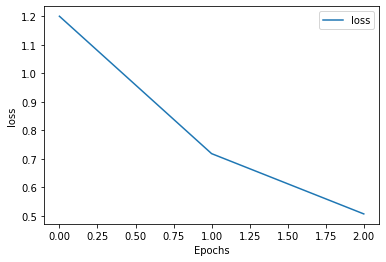

In [86]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()
plot_graphs(history, 'loss')

# bert를 활용한 한국어 텍스트 유사도 모델 

In [73]:
# 앞에서 사용한 quora question pair가 아닌 한글 텍스트 유사도 데이터셋을 활용함
# KorSTS 데이터셋 : STS문제를 해결하기 위한 데이터셋 (Semantic textual similarity) : 카카오 브레인에서 제공
# 한쌍의 텍스트에 대해 두 텍스트가 얼마나 유사한지 예측하는 묹제


In [1]:
!pip install mxnet

     |████████████████████████████████| 47.3 MB 1.4 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 6.8 MB 28.8 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 895 kB 59.6 MB/s 
     |████████████████████████████████| 596 kB 55.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install gluonnlp
# GluonNLP is a toolkit that enables easy text preprocessing, datasets loading and neural models building to help you speed up your Natural Language Processing (NLP) research.

     |████████████████████████████████| 344 kB 5.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595734 sha256=30f97aa3c517d5ce9751944d151a5d1f2a286841618560ab8cfe579da89f6bf8
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp


In [32]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from transformers import BertTokenizer 
from gluonnlp.data import SentencepieceTokenizer


In [33]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 28 * 2 


In [15]:
DATA_IN_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_in/KOR'
TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')
train_data = pd.read_csv(TRAIN_STS_DF, sep='\t', quoting = 3)
train_data.head(10)

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.
5,main-captions,MSRvid,2012test,11,4.25,몇몇 남자들이 싸우고 있다.,두 남자가 싸우고 있다.
6,main-captions,MSRvid,2012test,12,0.50,남자가 담배를 피우고 있다.,남자가 스케이트를 타고 있다.
7,main-captions,MSRvid,2012test,13,1.60,남자가 피아노를 치고 있다.,남자가 기타를 연주하고 있다.
8,main-captions,MSRvid,2012test,14,2.20,한 남자가 기타를 치고 노래를 부르고 있다.,한 여성이 어쿠스틱 기타를 연주하고 노래를 부르고 있다.
9,main-captions,MSRvid,2012test,16,5.00,사람이 고양이를 천장에 던지고 있다.,사람이 고양이를 천장에 던진다.


In [16]:
print('전체 train data 개수 : {}'.format(len(train_data)))

# 학습데이터의 경우, 기계번역을 통해 데이터셋을 구축, 나머지 평가 및 검증 데이터셋은 사람이 직접 번역해서 나온 데이터

전체 train data 개수 : 5749


In [17]:
train_set = pd.Series(train_data['sentence1'].tolist() + train_data['sentence2'].tolist()).astype(str)

print('전체 문장 데이터 개수 :{}'.format(len(train_set)))
print('유일한 총 문장수 :{}'.format(len(np.unique(train_set))))
print('반복해서나타나는 문장의수 : {}'.format(np.sum(train_set.value_counts()>1)))


전체 문장 데이터 개수 :11498
유일한 총 문장수 :10383
반복해서나타나는 문장의수 : 716


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Text(0, 0.5, 'probability')

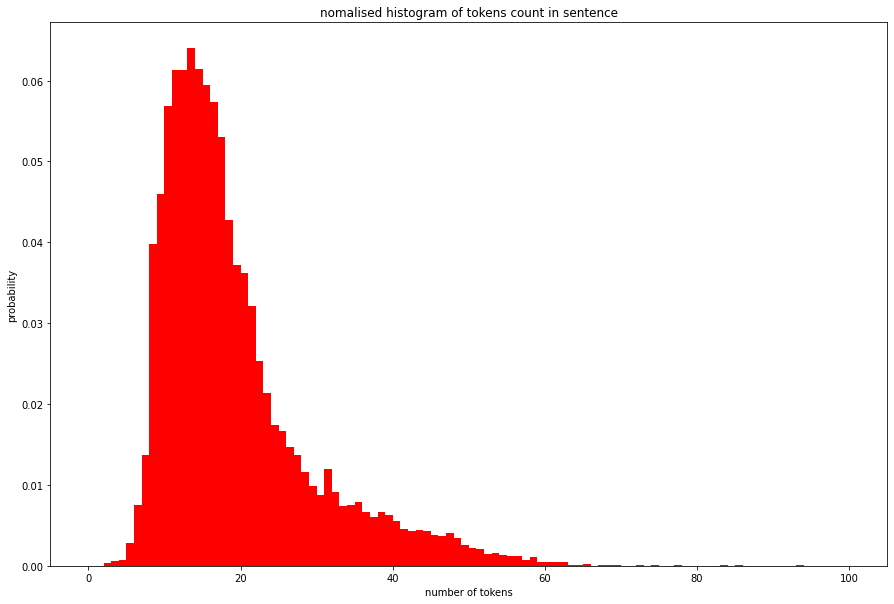

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
train_bert_token_cased_counts = train_set.apply(lambda x: len(tokenizer.tokenize(x)))
# kornli데이터 분석과 마찬가지로 음절단위, 띄어쓰기 단위등 분석결과가 있고, 여기서는 버트 토크나이저를 사용해 길이 분석을 진행
# 길이가 25에 몰려있는것을 알 수 있음
plt.figure(figsize=(15,10))
plt.hist(train_bert_token_cased_counts, bins=100, range = [0,100], facecolor='r', density=True, label= 'train')
plt.title('nomalised histogram of tokens count in sentence')
plt.xlabel('number of tokens')
plt.ylabel('probability')


In [19]:
print('문장 토큰 개수 최대값 :{}'.format(np.max(train_bert_token_cased_counts)))
print('문장 토큰 개수 평균값 :{}'.format(np.mean(train_bert_token_cased_counts)))

문장 토큰 개수 최대값 :102
문장 토큰 개수 평균값 :18.740302661332407


(-0.5, 799.5, 599.5, -0.5)

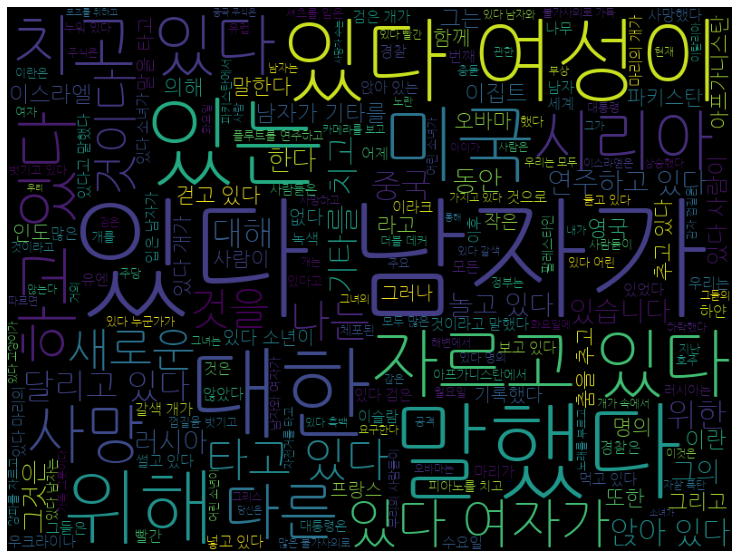

In [22]:
# wordcloud만들기
from wordcloud import WordCloud
font_path = os.path.join('/content/', 'NanumGothicLight.ttf')
cloud = WordCloud(font_path = font_path, width = 800, height = 600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis("off")
# 남자가 여성이 미국 말했다 라는 단어가 주로 사용됨

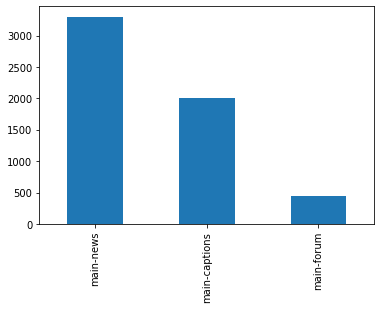

In [23]:
train_data.genre.value_counts().plot(kind='bar') # 장르컬럼의 각각의 빈도수를 확인

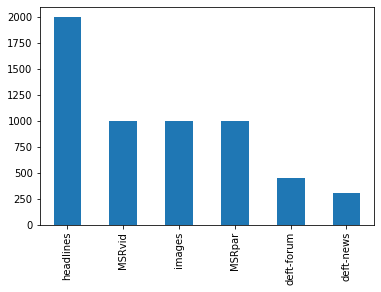

In [24]:
train_data.filename.value_counts().plot(kind='bar') # 파일이름컬럼의 각각의 빈도수를 확인

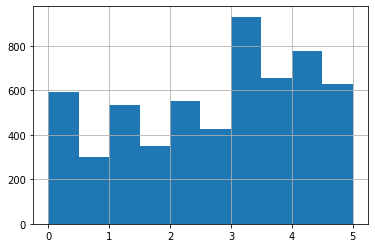

In [25]:
train_data.score.hist()

In [26]:
#  데이터 전처리
# NLI데이터셋 전처리와 거의 비슷하게 진행
# tsv파일을 불러오기 위해 delimiter를  '\t'로 설정함
TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')
DEV_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-dev.tsv')

train_data = pd.read_csv(TRAIN_STS_DF, header = 0, delimiter= '\t', quoting=3)
test_data = pd.read_csv(DEV_STS_DF, header = 0, delimiter= '\t', quoting=3)
print("total # of dataset : train {}, test {}".format(len(train_data), len(test_data)))

total # of dataset : train 5749, test 1500


In [27]:
train_data.head(5)

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.


In [28]:
test_data.head(5)

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,0,5.00,안전모를 가진 한 남자가 춤을 추고 있다.,안전모를 쓴 한 남자가 춤을 추고 있다.
1,main-captions,MSRvid,2012test,2,4.75,어린아이가 말을 타고 있다.,아이가 말을 타고 있다.
2,main-captions,MSRvid,2012test,3,5.00,한 남자가 뱀에게 쥐를 먹이고 있다.,남자가 뱀에게 쥐를 먹이고 있다.
3,main-captions,MSRvid,2012test,7,2.40,한 여성이 기타를 연주하고 있다.,한 남자가 기타를 치고 있다.
4,main-captions,MSRvid,2012test,8,2.75,한 여성이 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.


In [29]:
test_data# 불러온 데이터를 nli데이터셋 전처리한 것과 동일하게 전처리함
# 다른점이 있다면 라벨값을 실수값 그대로 넣어주면됨

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    # For Two setenece input
    
    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus


In [30]:
def clean_text(sent):
    sent_clean = re.sub("[^a-zA-Z0-9ㄱ-ㅣ가-힣\\s]", " ", sent)
    return sent_clean


In [49]:
# 앞에서 정의한 bert_tokenizer_v2함수와 clean_text함수를 사용해서 데이터를 전처리 / train 
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

import re

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []


for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing

In [50]:
train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)
train_data_labels = np.array(data_labels)

In [51]:
# 앞에서 정의한 bert_tokenizer_v2함수와 clean_text함수를 사용해서 데이터를 전처리 / test

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in test_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing

In [52]:

dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids, dev_attention_masks, dev_type_ids)
dev_data_labels = np.array(data_labels)

In [53]:
train_input_ids

array([[  101,  9379, 25549, ...,     0,     0,     0],
       [  101,  9954, 76854, ...,     0,     0,     0],
       [  101,  9954, 76854, ...,     0,     0,     0],
       ...,
       [  101,  9318, 56645, ...,     0,     0,     0],
       [  101, 45397,  9640, ...,     0,     0,     0],
       [  101,  9935, 90833, ...,     0,     0,     0]])

In [54]:
train_attention_masks

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [55]:
train_type_ids

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [56]:
train_data_labels

array([5. , 3.8, 3.8, ..., 0. , 0. , 0. ])

In [57]:
train_input_ids.shape

(5749, 56)

In [58]:
train_data_labels.shape

(5749,)

In [59]:
dev_input_ids

array([[   101,   9521,  16617, ...,      0,      0,      0],
       [   101, 106320,  16985, ...,      0,      0,      0],
       [   101,   9954,  76854, ...,      0,      0,      0],
       ...,
       [   101,   9580, 119144, ...,      0,      0,      0],
       [   101,   9580,  42144, ...,      0,      0,      0],
       [   101,  39773,   9379, ...,      0,      0,      0]])

In [60]:
dev_attention_masks

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [61]:
dev_type_ids

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [66]:
dev_data_labels

array([5.  , 4.75, 5.  , ..., 2.  , 0.  , 0.  ])

In [63]:
dev_input_ids.shape

(1500, 56)

In [65]:
dev_data_labels.shape

(1500,)

In [70]:
# korsts학습
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from transformers import BertModel, BertConfig
import torch

class TFBertRegressor(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertRegressor, self).__init__()
        
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.num_class = num_class
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.regressor = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="regressor")
        
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.regressor(pooled_output)

        return logits

In [71]:

regression_model = TFBertRegressor(model_name='bert-base-multilingual-cased',  # hugging face의 모델명
                                  dir_path='bert_ckpt',  # pretrained 가 저장된 폴더위치
                                  num_class=1)  # num_class가 1인 이유 : 두문장의 유사도를 계산하는 회귀 모델이기 때문에 1로 지정함


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [79]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):  # 커스텀 메트릭 모델을 구현하려면 우선 tf.keras.metrics.Metric 상속받음
  def __init__(self, name='person_correlation', **kwargs):
    super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
    self.y_true_list = []
    self.y_pred_list = []

  def update_state(self, y_true, y_pred, sample_weight= True):  #배치마다 나오는 결괏값들을 평가 함수에 적용하는 메서드
    # 해당 배치의 평균 표준편차를 사용하는게 아니 전체 데이터의 예측값 분포, 실제값 분포에 대한 평균과 표준편차를 이용해야하기 때문에 배치마다 나오는 예측 라벨값을 리스트에 추가함
    y_true = tf.reshape(y_true, shape = [-1])
    y_pred = tf.reshape(y_pred, shape = [-1])
    self.y_true_list.append(y_true)
    self.y_pred_list.append(y_pred)
  
  def result(self): # 두 분포를 사용해 실제 평가값인 피어슨 상관계수를 만드는 과정
  # https://supermemi.tistory.com/11 : tf.concat 설명,  장난감 블록을 붙이듯 axis 축에 대하여 자료를 합체시키는 것
  #( 2차원, 1차원 ) 으로 위치를 생각하면 쉽다.
  #( axis=0 , axis=1 )
  #( axis=-2 , axis =-1 )

  # 3차원이 된다면 앞쪽에 숫자하나를 더 넣어주면 된다.

  #( 3차, 2차, 1차 ) 이런식으로 차원이 추가 될 수록 덧붙여진다.
  # ( axis=0, axis=1, axis=2)
  # ( axis=-3, axis=-2 , axis =-1 )


    y_true = tf.concat(self.y_true_list, -1)
    y_pred = tf.concat(self.y_pred_list, -1)
    pearson_correlation = self.pearson(y_true, y_pred)
    return pearson_correlation

  def reset_states(self): # 각 에폭이 끝난후 다음 에폭에서의 평가값을 뽑기 위해서는 새롭게 평가를 해야함
    self.y_true_list = []
    self.y_pred_list = []

  def pearson(self, true, pred): 
    # 텐서플로우 차원을 줄이면서 연산하는 대표적인 함수 reduce_sum과 reduce_mean함수
    # reduce_sum은 특정 차원을 제거하고 합계를 구하고 reduce_mean은 특정 차원을 제거하고 평균을 구한다.

    m_true = tf.reduce_mean(true)
    m_pred = tf.reduce_mean(pred)
    m_true, m_pred = true-m_true, pred-m_pred # x_i - xbar, y_i - ybar
    num = tf.reduce_sum(tf.multiply(m_true, m_pred)) 
    den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12 

    return num/den

In [80]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer = optimizer, loss= loss, metrics = [metric], run_eagerly= True)
# run_eagerly= True : 사용자 평가지표 모듈을 사용할때 에러가 발생하지 않게해줌

In [81]:
model_name = 'tf2_BERT_KorSTS'

In [82]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
DATA_OUT_PATH = '/content/'

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_pearson_correlation', min_delta=0.0001,patience=2,mode='max') 
# mode라는 인자가 들어감 사용자 지정 평가지표를 사용할 경우에 해당 지표가 높은게 좋은지 낮은게 좋은지에 대한 기준 제시
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True,mode='max')


/content/tf2_BERT_KorSTS -- Folder already exists 



In [83]:
# 학습과 eval 시작
history = regression_model.fit(train_inputs, train_data_labels, epochs=NUM_EPOCHS,
            validation_data = (dev_inputs, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

Epoch 1/3
180/180 [==============================] - ETA: 0s - loss: 1.2002 - person_correlation: 0.6671

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1841: UserWarning: Metric PearsonCorrelationMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


180/180 [==============================] - 127s 704ms/step - loss: 1.2002 - person_correlation: 0.6671 - val_loss: 0.7781 - val_person_correlation: 0.8135
Epoch 2/3
180/180 [==============================] - 119s 663ms/step - loss: 0.7180 - person_correlation: 0.8157 - val_loss: 0.7329 - val_person_correlation: 0.8250
Epoch 3/3
180/180 [==============================] - 118s 657ms/step - loss: 0.5064 - person_correlation: 0.8740 - val_loss: 0.8055 - val_person_correlation: 0.8113
{'loss': [1.2002311944961548, 0.7180095314979553, 0.5064431428909302], 'person_correlation': [0.6670516729354858, 0.8156927824020386, 0.8740189075469971], 'val_loss': [0.778110682964325, 0.7328692078590393, 0.8055381774902344], 'val_person_correlation': [0.8134546875953674, 0.8249849081039429, 0.8113155364990234]}


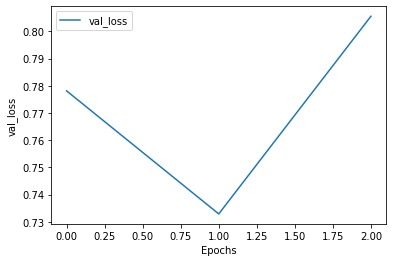

In [91]:
plot_graphs(history, 'val_loss')


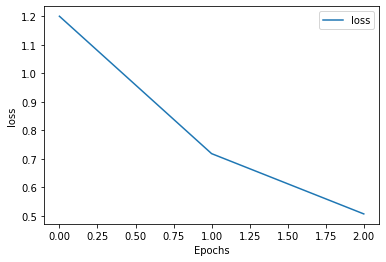

In [92]:
plot_graphs(history, 'loss')

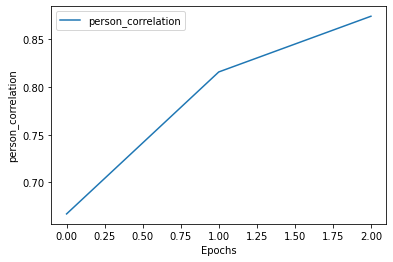

In [94]:
plot_graphs(history, 'person_correlation')

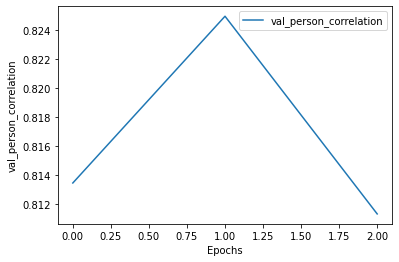

In [95]:
plot_graphs(history, 'val_person_correlation')

In [84]:
print(history.history)

{'loss': [1.2002311944961548, 0.7180095314979553, 0.5064431428909302], 'person_correlation': [0.6670516729354858, 0.8156927824020386, 0.8740189075469971], 'val_loss': [0.778110682964325, 0.7328692078590393, 0.8055381774902344], 'val_person_correlation': [0.8134546875953674, 0.8249849081039429, 0.8113155364990234]}


In [98]:
# korsts 모델 테스트
# Load Test dataset
TEST_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-test.tsv')

test_data = pd.read_csv(TEST_STS_DF, header=0, delimiter = '\t', quoting = 3)
test_data.head()

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,24,2.5,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.
1,main-captions,MSRvid,2012test,33,3.6,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.
2,main-captions,MSRvid,2012test,45,5.0,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.
3,main-captions,MSRvid,2012test,63,4.2,한 남자가 오이를 자르고 있다.,한 남자가 오이를 자르고 있다.
4,main-captions,MSRvid,2012test,66,1.5,한 남자가 하프를 연주하고 있다.,한 남자가 키보드를 연주하고 있다.


In [99]:
# Test set도 똑같은 방법으로 구성한다.
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in test_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)
test_data_labels = np.array(data_labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing

In [100]:
print("# sents: {}, # labels: {}".format(len(test_input_ids), len(test_data_labels)))

# sents: 1379, # labels: 1379


In [101]:
#regression_model.load_weights(checkpoint_path)

results = regression_model.evaluate(test_inputs, test_data_labels, batch_size=512)
print("test loss, test pearson correlation: ", results)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1841: UserWarning: Metric PearsonCorrelationMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


3/3 [==============================] - 2s 775ms/step - loss: 1.0115 - person_correlation: 0.7704
test loss, test pearson correlation:  [1.0114507675170898, 0.770426869392395]
